In [14]:
import pandas as pd
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt 
import homogeneidad as hm
import funcion_objetivo as fo
import seaborn as sns

In [15]:
%load_ext autoreload
%autoreload 2

In [17]:
path = r'G:\Unidades compartidas\Simulacion Hidrologica\Trabajo_2\Codigo\datos'
files = os.listdir(path)[:6]
cne = pd.read_csv(r'G:\Unidades compartidas\Simulacion Hidrologica\Trabajo_2\Codigo\datos\Catalogo_Estaciones_IDEAM.csv',
                  index_col='Codigo')

In [18]:
def llenar_na(df):
    # Seleccion de fechas
    fecha_inicio = df.index[0]
    fecha_final = df.index[-1]
    # Generacion lista con fecha
    rango_fechas = pd.date_range(fecha_inicio,fecha_final,freq='d')
    # re-index de datos 
    df = df.reindex(rango_fechas)

    return df

In [19]:
def figuras(df, estacion):
    plt.figure(figsize=(10,5))
    plt.plot(df)

    plt.title(estacion)
    plt.ylabel('precipitación(mm)')

    plt.grid()

    plt.tight_layout()

In [20]:
# Lectura y almacenamiento de los datos en un diccionario 
dict_datos = {

}

for archivo in files:
    codigo = int(archivo.split('@')[1].split('.')[0])
    nombre_archivo = os.path.join(path,archivo)
    df = pd.read_csv(nombre_archivo,sep='|',
                     usecols=['Fecha','Valor'],
                     index_col='Fecha')
    # Poner fecha en formato fecha
    df.index = pd.to_datetime(df.index)
    # Se rellenan generan datos vacios
    df_relleno = llenar_na(df)
    #nombre estacion
    nombre_estacion = cne.at[codigo,'Nombre']
    #almacenamiento datos
    dict_datos[nombre_estacion] = df_relleno 

IndexError: list index out of range

In [39]:
# Estaciones a utilizar
# Se eliminan las estaciones con mala calidad de datos
llaves = list(dict_datos.keys())

for llave in llaves:

    if llave == 'CUATRO ESQUINAS  [26180040]' or llave == 'GUAIMARAL  [26180050]' or llave == 'MESOPOTAMIA  [26180080]':
        dict_datos.pop(llave)

## Análisis de homogeneidad

In [40]:
# Diccionarios vacios para almacenar los datos
dic_mk = {

}

dic_pettit = {

}

# Pruebas de homogeneidad
llaves = dict_datos.keys()
for llave in llaves:
    df = dict_datos[llave]
    # Restriccion de los datos al periodo con mayor consistencia
    df_acotado = df[(df.index > '1999') & (df.index < '2013')]

    resultados_mk = hm.mann_kendall(df_acotado,'pptn')
    resultados_pettit = hm.pettit(df_acotado,'pptn')

    dic_mk[llave] = resultados_mk
    dic_pettit[llave] = resultados_pettit

    #df_acotado.resample('YE').sum().plot()

### Revision de datos de caudal 

In [41]:
path_caudal = r'H:\Unidades compartidas\Simulacion Hidrologica\Trabajo_2\Datos'
archivo = 'q_medio_d_26187030.csv'
nombre = os.path.join(path_caudal,archivo)
df_caudal = pd.read_csv(nombre,index_col='Unnamed: 0')
df_caudal.index = pd.to_datetime(df_caudal.index)

In [77]:
df_relleno = llenar_na(df_caudal)
q_acotado = df_relleno[(df_relleno.index >= '1999') & (df_relleno.index < '2013')]
resultados_mk = hm.mann_kendall(q_acotado,'caudal')
resultados_pettit = hm.pettit(q_acotado,'caudal')

## Generación de la serie de precipitación 
El procedimiento a realizar es el siguiente:
- Revisar datos faltantes
- rellenar en caso de ser necesario
- Utilizar el metodo de IDW para estimar la precipitacion en un punto

In [43]:
# Se utilizan los datos de precipitacion acotados entre 1999-2013
llaves = list(dict_datos.keys())
dic_pptn = {

}

df_pptn = [

]

for llave in llaves:
    df = dict_datos[llave]
    df.rename(columns = {'Valor':llave}, inplace = True)
    # Restriccion de los datos al periodo con mayor consistencia
    df_acotado = df[(df.index > '1999') & (df.index < '2013')]
    dic_pptn[llave] = df_acotado
    # Almacenamiento en lista, para luego unir en un unico dataframe
    
    df_pptn.append(df_acotado)
    


In [44]:
# Calculo de los parametros alpha para la serie
distancias = [
    16.25,
    18.28,
    3.47,
]
alphas = [

]

for distancia in distancias:
    
    #Estimacion del alpha
    denominador = np.sum([1/dist for dist in distancias])
    alpha = (1/distancia)/denominador

    alphas.append(alpha)

# Alfa debe sumar siempre 1.0

In [45]:
# Almacenamiento de los datos en un unico dataframe 
pptn = {llave:np.array(dic_pptn[llave].iloc[:,0]) for llave in llaves}
pptn_df = pd.DataFrame.from_dict(pptn)
pptn_df.index = dic_pptn[llaves[0]].index
# Se estima la serie de precipitacion representante de la cuenca


In [46]:
# Relleno de las estaciones
# Para rellenar las series se utiliza el metodo de la razon normal

cols = list(pptn_df.columns)
Ns = np.array(pptn_df.resample('YE').sum().mean())
dic_media_pptn = {k:v for k,v in zip(cols,Ns)}


Para rellenar las estaciones se utilizó el método de la razón normal. Al tener las estaciones sin faltantes, se aplicó el método IDW utilizando el centroide de la cuenca para generar una serie de datos continua entre 1999-2013. Periodo para el cual se presentaba mejor homogeneidad

In [47]:
for col in cols:
    # Crea una copia de la lista de columnas, se actualiza cada vez que se corre el codigo
    col2 = list(pptn_df.columns)
    col2.remove(col)
    for date in pptn_df.index:
        Nx = dic_media_pptn[col]
        #Lista de columnas a revisar
        # Lista de valores medios mulianuales
        Ns = [dic_media_pptn[col] for col in col2]
        # Verifica si el punto esta vacio
        if pd.isna(pptn_df.at[date,col]):
            # Esta linea extrae los valores de precipitacion de las otras columnas
            Pi = [pptn_df.at[date,col] for col in col2]
            # Se realiza un calculo parcial del metodo de razon normal
            parte_1 = [(Nx/Ni)*Pi for Ni,Pi in zip(Ns,Pi)]
            # Se realiza el relleno de la precipitacion, se ignoran los Na en otras columnas
            Px = np.nanmean(parte_1)
            # Se actualiza el valor de precipitacion
            pptn_df.at[date,col] = Px

# Aplicacion del metodo IDW para generar un unico dataframe de datos para la zona
pptn_df['pptn'] = pptn_df['ARGELIA [23055070]']*alphas[0] + \
                pptn_df['ABEJORRAL [26180160]']*alphas[1] + \
                pptn_df['SONSON [26180180]']*alphas[2] 

        


## GR4J 
se corre el modelo GR4J el cual se obtuvo de `pagina de github`

In [48]:
# se importa el modelo
import gr4j as gr

0.31169


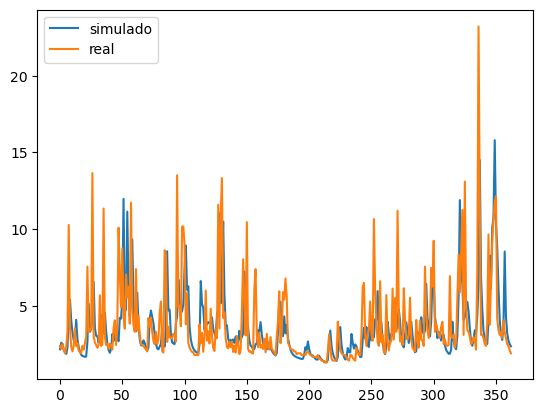

In [49]:
# Entradas de precipitacion y evapotranspiracion potencial 
#
etp = 4.658*np.exp(-0.0002*(2652.68)) #Budyko - Cenicafe
pptn = np.array(pptn_df['pptn'])[1:364]
etp_array = np.ones_like(pptn)*etp
# Parametros
dic_params = {
    'X1':3898.08, # 100-1200
    'X2':-7.099,    # -5 a 3
    'X3':50.1146,  # 20-300
    'X4':1.94916,  # 1.1-2.9
}
# Se pueden agregar condiciones iniciales
cond_iniciales = {

            'production_store': 0.61648 * dic_params['X1'],
            'routing_store': 0.75753 * dic_params['X3']
    }

q_real = np.array(q_acotado['Valor'])[1:364]
q_simulado = np.array(gr.gr4j(pptn,
                              etp_array,
                              dic_params,
                              cond_iniciales))

# Calculo Nash
nash = fo.nash_log(q_real,q_simulado)
print(nash)


plt.plot(q_simulado,label='simulado')
plt.plot(q_real,label='real')
plt.legend()

In [50]:
etp = 4.658*np.exp(-0.0002*(2652.68))

In [51]:
etp

2.7402527795697598

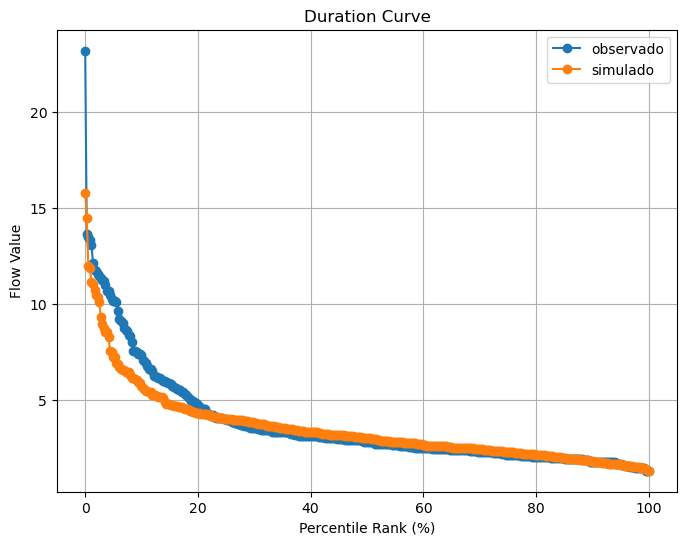

In [52]:
# Sort the flow data in descending order
q_obs = np.sort(q_real)[::-1]
q_sim =  np.sort(q_simulado)[::-1]

# Calculate the percentile ranks
perc_obs = np.linspace(0, 100, len(q_obs))
perc_sim = np.linspace(0, 100, len(q_sim))

# Plot the duration curve
plt.figure(figsize=(8, 6))
plt.plot(perc_obs, q_obs, marker='o', linestyle='-', label='observado')
plt.plot(perc_sim,q_sim,marker='o', linestyle='-', label = 'simulado')
plt.legend()
plt.xlabel('Percentile Rank (%)')
plt.ylabel('Flow Value')
plt.title('Duration Curve')
plt.grid(True)
plt.show()


## Auto calibracion con Monte-carlo:
Se calibra para un periodo de un año, utilizando una distribución de probabilidades uniforme.
Inicialmente se realizan 2000 iteraciones. La función objetivo es nash con raiz cuadrada para ajustarme mejor a los medio

In [53]:
pet_data = pd.read_csv('evapotranspiracion_potencial.csv',index_col='Date')

In [64]:
q_obs_entrada = q_acotado[(q_acotado.index > '1998-12-31') & (q_acotado.index <= '2008-12-31')]
pet_data_entrada = pet_data[(pet_data.index <= '2010-12-31' )]
pptn_entrada = pptn_df[(pptn_df.index > '1998-12-31') & (pptn_df.index <= '2008-12-31')]

In [65]:
pptn_entrada['pptn']

1999-01-01 07:00:00     8.637970
1999-01-02 07:00:00    10.552030
1999-01-03 07:00:00     7.663662
1999-01-04 07:00:00     2.875813
1999-01-05 07:00:00     4.371139
                         ...    
2008-12-26 07:00:00     0.289853
2008-12-27 07:00:00     0.121730
2008-12-28 07:00:00     0.121730
2008-12-29 07:00:00     1.700851
2008-12-30 07:00:00    11.106373
Freq: D, Name: pptn, Length: 3652, dtype: float64

In [66]:
# Simulacion Monte-carlo
import random

def monte_carlo():
    # Se aplican los intervalos sugeridos en (Perrin, 2003)
    X1 = random.uniform(3000, 4000) #100 - 1200
    X2 = random.uniform(-4, 2) #-5 - 3
    X3 = random.uniform(100, 200) #20 - 300
    X4 = random.uniform(1.10, 2.0) #1.1-2.9

    return X1,X2,X3,X4

def datos_iniciales():
    # Define las condiciones iniciales para el modelo
    x1 = random.uniform(0.6,0.8)
    x3 = random.uniform(0.6,0.8)

    return x1,x3

# Se ingresa el área de la cuenca
Area = 53.68 #Km2
# Evapotranspiracion potencial
etp = 4.658*np.exp(-0.0002*(2652.68))
# Datos entrada para calibracion
pptn_cal = np.array(pptn_entrada['pptn'])
etp_array_cal = np.ones_like(pptn_cal)*etp
# etp_array_cal = np.array(pet_data_entrada['Value'])
# q_obs = np.array(q_acotado['Valor'])[0:3649]
q_obs = np.array(q_obs_entrada)
# Parametros Extraidos de la simulacion

#Ciclo for para generar simulaciones 

# Diccionario que almacena los resultados de las iteraciones

resultados = {

    'X1':[],
    'X2':[],
    'X3':[],
    'X4':[],
    'CI_X1':[],
    'CI_X3':[],
    'FO1':[],
    'FO2':[],
    'FO3':[],    
}

# Lista que almacena los caudales simulados

simulaciones = [

]

# Se inicia con 2000 simulaciones
for i in range(2000):
    params = monte_carlo()

    dic_params = {
        'X1':params[0],  # 100-1200
        'X2':params[1],  # -5 a 3
        'X3':params[2],  # 20-300
        'X4':params[3],  # 1.1-2.9
    }

    # Genera el porcentaje de inicio del production store y el routing store
    x1,x3 = datos_iniciales()

    # Condicione iniciales para ingreso al modelo
    cond_iniciales = {

            'production_store': x1 * params[0],
            'routing_store': x3 * params[2]
    }

    # Se almacenan las condiciones iniciales
    resultados['CI_X1'].append(x1)
    resultados['CI_X3'].append(x3)

    q_simulado = np.array(gr.gr4j(pptn_cal,
                                  etp_array_cal,
                                  dic_params,
                                  cond_iniciales))
    
    # La Salida del modelo se da en mm, por lo cual se multiplica por el área de la cuenca y se divide por el factor de escalamiento
    q_simulado_escalado = q_simulado*(Area)/86.4
    
    # Se almacenan las simulaciones
    simulaciones.append(q_simulado_escalado)
    
    # Almacenamiento de resultados
    resultados['X1'].append(params[0])      
    resultados['X2'].append(params[1])  
    resultados['X3'].append(params[2])  
    resultados['X4'].append(params[3])

    # Almacenamiento resultados del nash
    resultados['FO1'].append(fo.nash_sqrt(q_obs,q_simulado_escalado))
    resultados['FO2'].append(fo.nash_log(q_obs,q_simulado_escalado))
    resultados['FO3'].append(fo.nash(q_obs,q_simulado_escalado))



In [67]:
resultado_mc = pd.DataFrame.from_dict(resultados)

In [68]:
resultado_mc[resultado_mc['FO1'] == resultado_mc['FO1'].max()]

,X1,X2,X3,X4,CI_X1,CI_X3,FO1,FO2,FO3
1088,3923.061301,-2.901327,155.871437,1.105822,0.649298,0.691274,0.42276,0.47348,0.32178


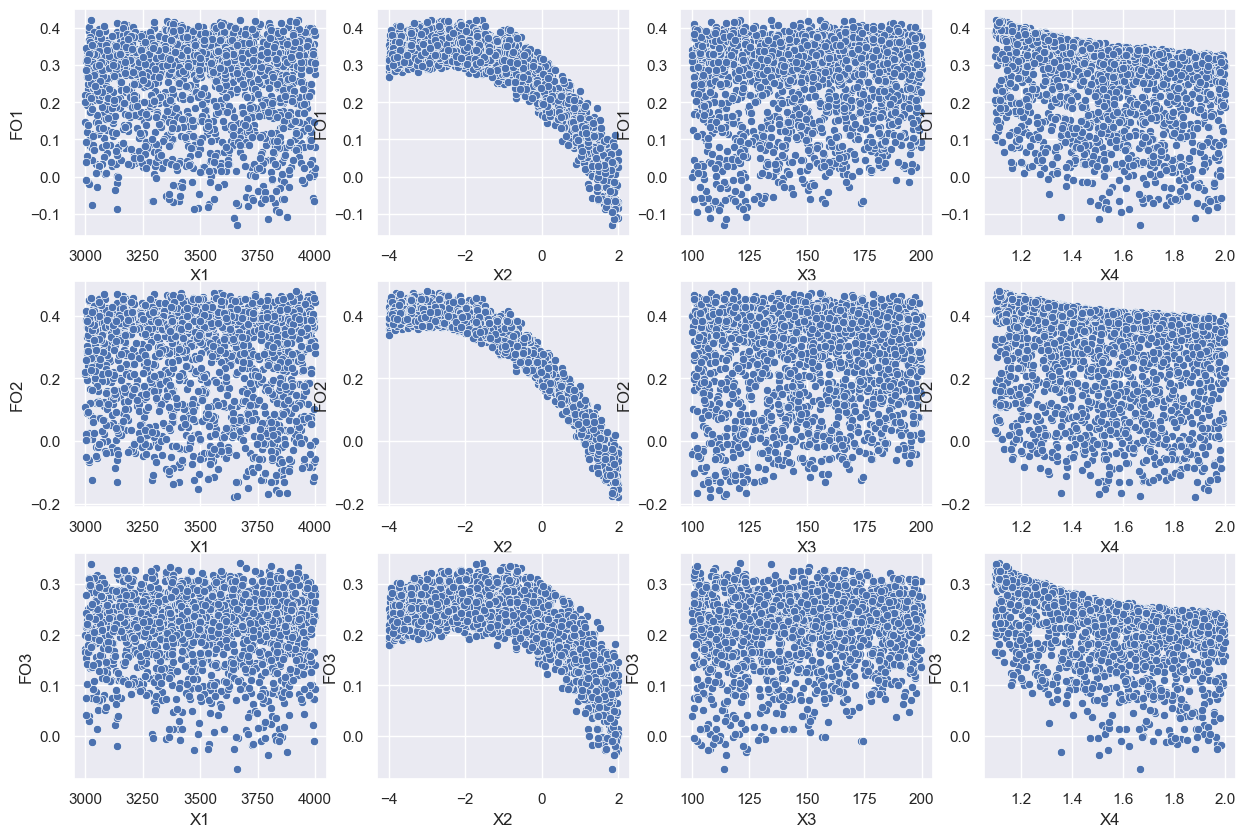

In [69]:
# Figuras de sensibilidad 
sns.set()
fig, axes = plt.subplots(3,4,
                         figsize=(15,10),
                         )


# Lista con 
params = list((resultado_mc.columns))[0:4]
fun_obj = list((resultado_mc.columns))[6:10]

for i in range(len(fun_obj)):
    for j in range(len(params)):

        # se crean los graficos
        sns.scatterplot(data=resultado_mc,
                        x=params[j], 
                        y=fun_obj[i],
                        ax=axes[i,j])


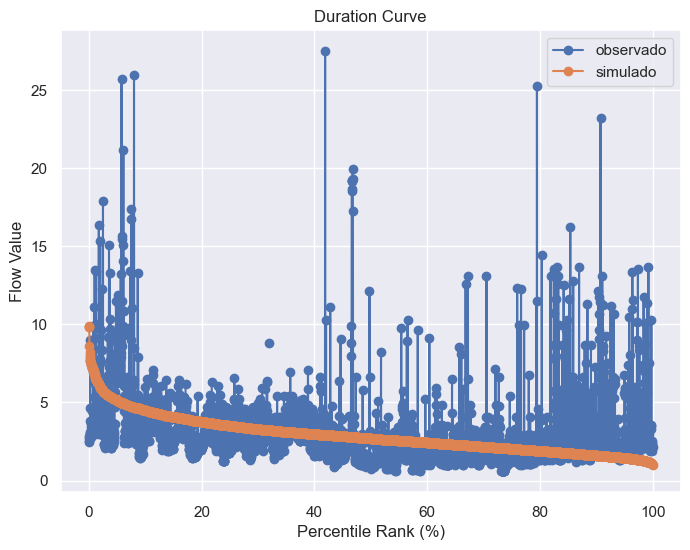

In [82]:
# Sort the flow data in descending order
q_sim = simulaciones[1088]

q_obs = np.sort(q_obs)[::-1]
q_sim =  np.sort(q_sim)[::-1]

# Calculate the percentile ranks
perc_obs = np.linspace(0, 100, len(q_obs))
perc_sim = np.linspace(0, 100, len(q_sim))

# Plot the duration curve
plt.figure(figsize=(8, 6))
plt.plot(perc_obs, q_obs, marker='o', linestyle='-', label='observado')
plt.plot(perc_sim,q_sim,marker='o', linestyle='-', label = 'simulado')
plt.legend()
plt.xlabel('Percentile Rank (%)')
plt.ylabel('Flow Value')
plt.title('Duration Curve')
plt.grid(True)
plt.show()

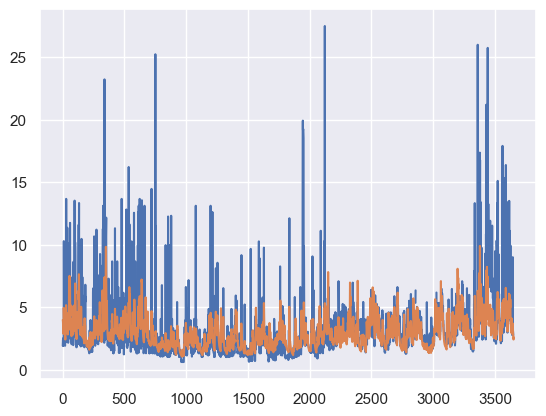

In [83]:
plt.plot(np.array(q_acotado)[0:3649])
plt.plot(simulaciones[1088])


In [ ]:
# Metodologia GLUE

# Tercer paso: Establecer umbral de simulaciones buenas, en este caso FO2 > 0.4
resultados_umbral = resultado_mc[resultado_mc['FO2'] >= 0.5]
resultados_sort = resultados_umbral.sort_values(by=['FO2'], ascending=False)
# Cuarto punto Normalizar los resultados
resultados_sort['Normalizado'] = resultados_sort['FO2']/np.sum(resultados_sort['FO2'])
# Crear Data frame con todos los caudales simulados

In [ ]:
dic_glue = {
    
}

for id in resultados_sort.index:
    
    col = str(np.round(resultados_sort.at[id,'Normalizado'],5))
    col_name = 'P_' + col +'_{}'.format(id)
    dic_glue[col_name] = simulaciones[id]



In [ ]:
df_glue = pd.DataFrame.from_dict(dic_glue)

In [ ]:
df_glue

,P_0.00034_6843,P_0.00034_2140,P_0.00034_1070,P_0.00034_354,P_0.00034_7464,P_0.00034_4684,P_0.00034_1356,P_0.00034_4221,P_0.00034_2983,P_0.00034_3100,...,P_0.00026_2993,P_0.00026_8859,P_0.00026_2989,P_0.00026_1170,P_0.00026_8843,P_0.00026_4880,P_0.00026_6167,P_0.00026_7684,P_0.00026_3324,P_0.00026_1446
0,1.222664,1.817303,2.422417,2.220849,1.459122,2.463911,1.633303,1.933104,1.959904,1.671672,...,2.569073,2.889645,2.242817,1.968205,2.505839,1.388755,1.971392,2.759212,2.933114,5.058121
1,1.906360,2.496701,2.907395,2.582010,2.145270,2.666781,2.356194,2.446165,2.347590,2.249300,...,3.449594,3.536594,4.153329,2.437184,2.789698,2.908557,2.962444,3.652487,3.094441,4.369981
2,2.192280,2.553942,2.767587,2.473453,2.343318,2.498552,2.478907,2.447967,2.316538,2.288642,...,3.438922,3.634545,4.399583,2.586937,2.757442,3.500878,3.397322,3.828046,2.933296,3.665299
3,2.058453,2.202953,2.315107,2.102862,2.110376,2.155782,2.182123,2.110143,2.028313,2.012253,...,3.021797,3.297307,3.805872,2.438159,2.515545,3.279969,3.249334,3.519024,2.599604,3.025286
4,2.044597,2.097026,2.164678,1.956329,2.051300,1.995055,2.093958,1.995681,1.903741,1.914043,...,2.854764,3.162249,3.686516,2.385758,2.382593,3.257516,3.241024,3.406706,2.418485,2.660359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,3.306433,3.101565,3.167443,3.239437,3.173861,3.410445,3.147927,3.204977,3.492663,3.106981,...,3.699738,4.210568,2.939362,4.491746,4.564966,3.283149,4.002421,3.797313,4.414559,4.508275
360,2.795095,2.643966,2.714186,2.743339,2.680379,2.913071,2.685050,2.728867,2.953128,2.669741,...,3.141469,3.556193,2.535665,3.824127,3.905584,2.852985,3.365440,3.233788,3.803109,3.873017
361,2.522647,2.414331,2.488073,2.481725,2.422377,2.638427,2.451824,2.483840,2.660142,2.449993,...,2.848274,3.160436,2.341427,3.413749,3.493706,2.643599,2.991957,2.908203,3.436014,3.480006
362,2.358378,2.281104,2.357628,2.324998,2.268653,2.469312,2.316092,2.339840,2.480839,2.322697,...,2.671568,2.898655,2.230725,3.139423,3.215081,2.524516,2.750232,2.700602,3.195786,3.216346


In [ ]:
np.quantile(np.array(df_glue.iloc[0,:]),0.05)

1.0882064560402185

In [ ]:

df_glue['q_5'] = [np.quantile(np.array(df_glue.iloc[i,:]),0.05) for i in df_glue.index]
df_glue['q_95'] = [np.quantile(np.array(df_glue.iloc[i,:]),0.95) for i in df_glue.index]

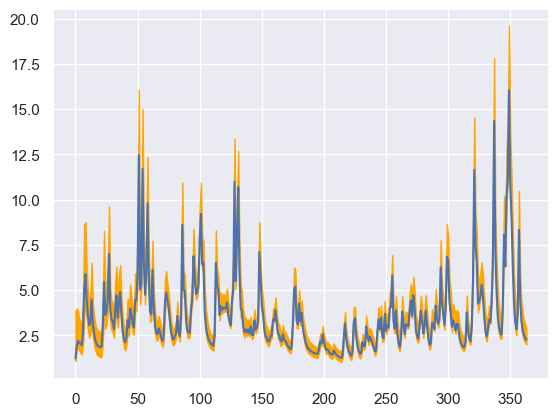

In [ ]:
x = range(0,364)
plt.plot(simulaciones[6843])
plt.fill_between(x,df_glue['q_5'],df_glue['q_95'], color='orange')


In [ ]:

for archivo in files:

    prueba = os.path.join(path,archivo)
    datos = pd.read_csv(prueba,sep='|',index_col='Fecha')
    datos.index = pd.to_datetime(datos.index)
    datos_2 = llenar_na(datos)
    codigo = archivo.split('@')[1].split('.')[0]
    nombre = cne.at[int(codigo),'Nombre']
    plt.figure(figsize=(13,8))
    plt.plot(datos_2)
    plt.title('Serie de precipitación estación {}'.format(nombre),fontsize=17)
    plt.ylabel('Precipitacion (mm)',fontsize=15)
    plt.grid()

    path_guardado = r'G:\Unidades compartidas\Simulacion Hidrologica\Trabajo_2\Codigo\Figuras'
    nombre_ = nombre+'.png'

    nombre_guardado = os.path.join(path_guardado,nombre)
    plt.tight_layout()
    plt.savefig(nombre_guardado)
    plt.close()

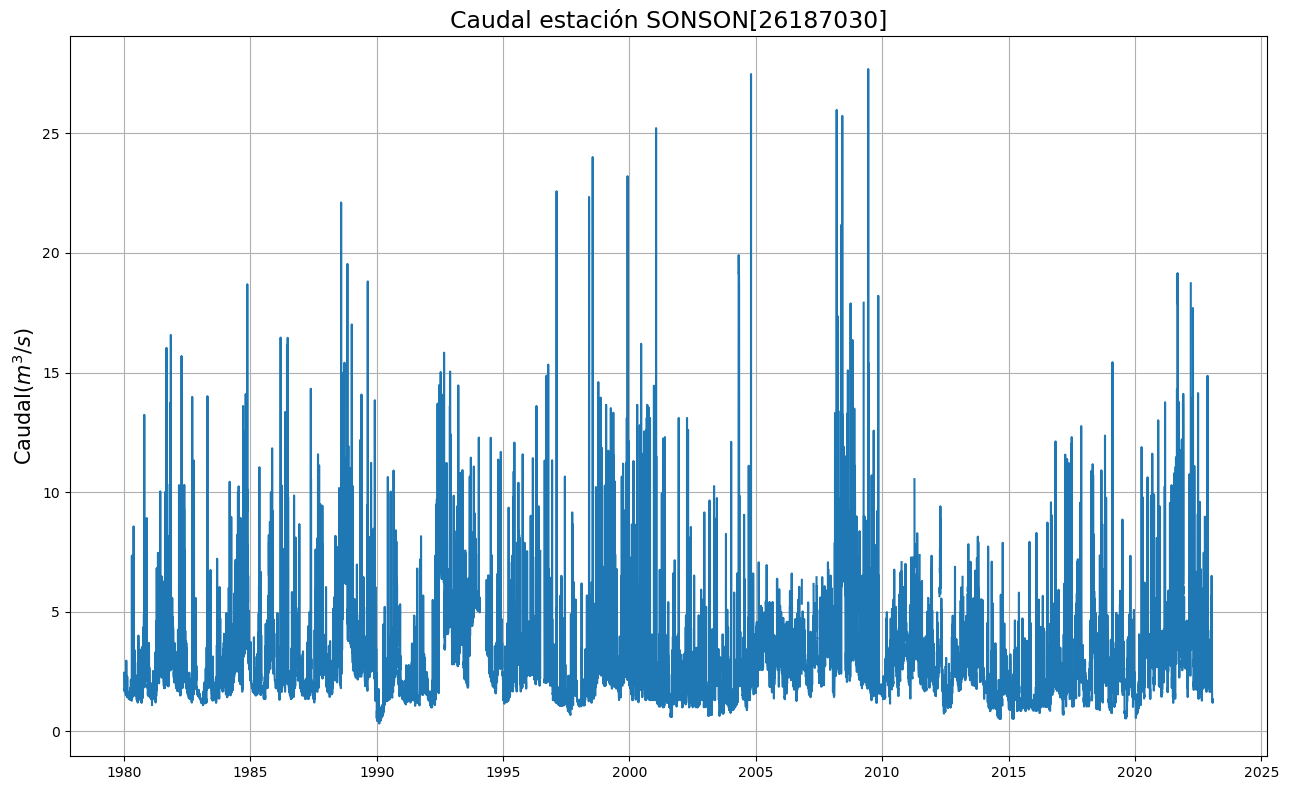

In [ ]:
plt.figure(figsize=(13,8))
plt.plot(df_relleno[df_relleno.index > '1980'])
plt.title('Caudal estación SONSON[26187030]',fontsize=17)
plt.ylabel('Caudal($m^3/s$)',fontsize=15)
plt.grid()
path_guardado = r'G:\Unidades compartidas\Simulacion Hidrologica\Trabajo_2\Codigo\Figuras'
nombre_ = 'Figura_caudal' + '.png'
nombre_guardado = os.path.join(path_guardado,nombre_)
plt.tight_layout()
plt.savefig(nombre_guardado)
# plt.close()

In [ ]:
q_obs_entrada = q_acotado[(q_acotado.index > '1998-12-31') & (q_acotado.index <= '2008-12-31')]
pet_data_entrada = pet_data[(pet_data.index <= '2010-12-31' )]
pptn_entrada = pptn_df[(pptn_df.index > '1998-12-31') & (pptn_df.index <= '2008-12-31')]

,Valor
1999-01-02,2.140
1999-01-03,2.380
1999-01-04,2.200
1999-01-05,2.500
1999-01-06,2.080
...,...
2012-12-27,3.560
2012-12-28,2.135
2012-12-29,1.967
2012-12-30,1.958


In [87]:
# Validación 
# Entradas de precipitacion y evapotranspiracion potencial 
#
etp = 4.658*np.exp(-0.0002*(2652.68)) #Budyko - Cenicafe
pptn = np.array(pptn_df['pptn'])
etp_array = np.ones_like(pptn)*etp
# Parametros
dic_params = {
    'X1':3459.869478, # 100-1200
    'X2':-3.950231,    # -5 a 3
    'X3':182.787417,  # 20-300
    'X4':1.470888,  # 1.1-2.9
}
# Se pueden agregar condiciones iniciales
cond_iniciales = {

            'production_store': 0.64206 * dic_params['X1'],
            'routing_store': 0.609166 * dic_params['X3']
    }

q_real = np.array(q_acotado['Valor'])
q_simulado = np.array(gr.gr4j(pptn,
                              etp_array,
                              dic_params,
                              cond_iniciales))

q_simulado_escal = q_simulado*Area/86.4

# Calculo Nash
nash = fo.nash_log(q_real,q_simulado_escal)





In [88]:
nash

0.50233

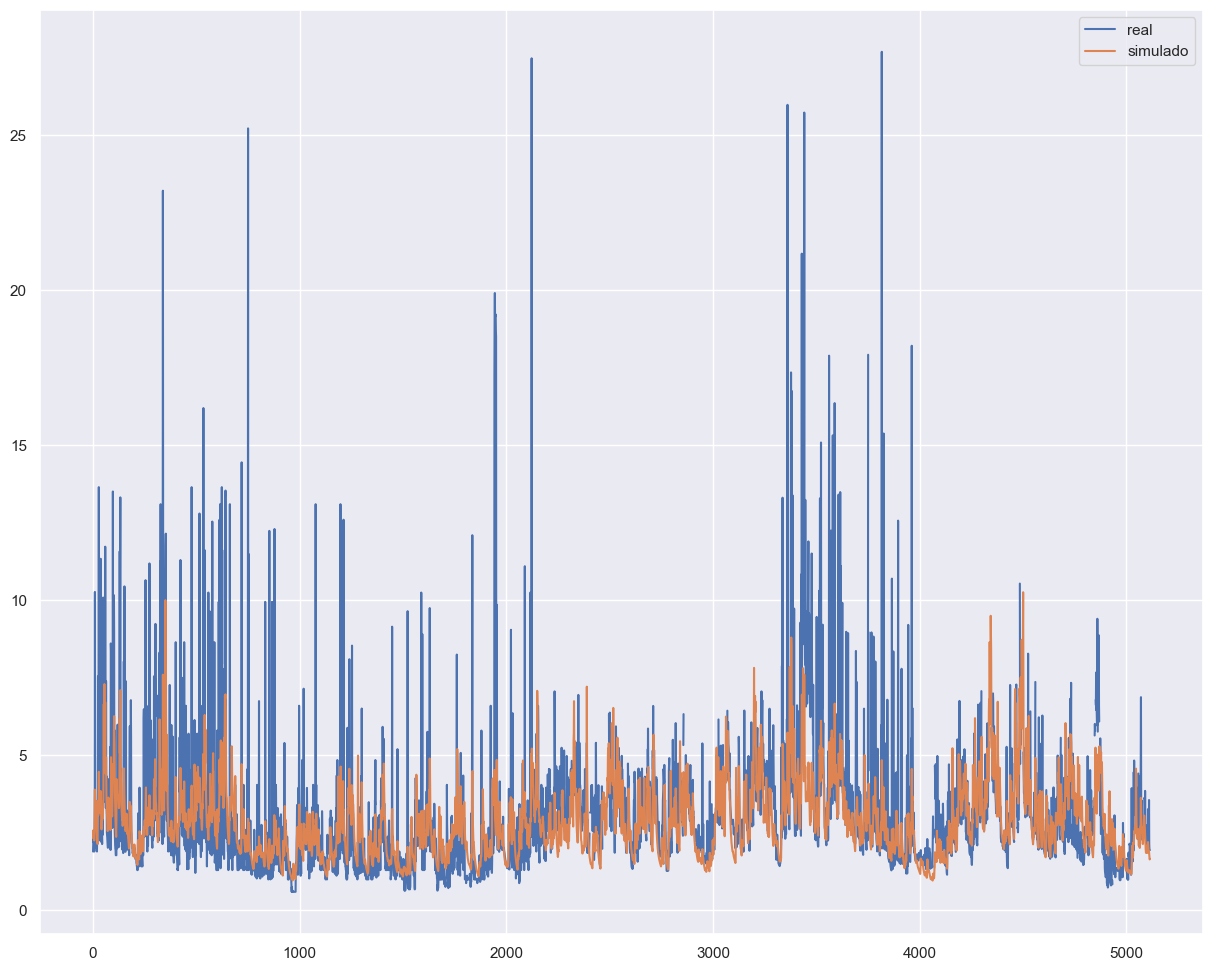

In [89]:
plt.figure(figsize=(15,12))
plt.plot(q_real,label='real')
plt.plot(q_simulado_escal,label='simulado')
plt.legend()

AttributeError: Line2D.set() got an unexpected keyword argument 'width'

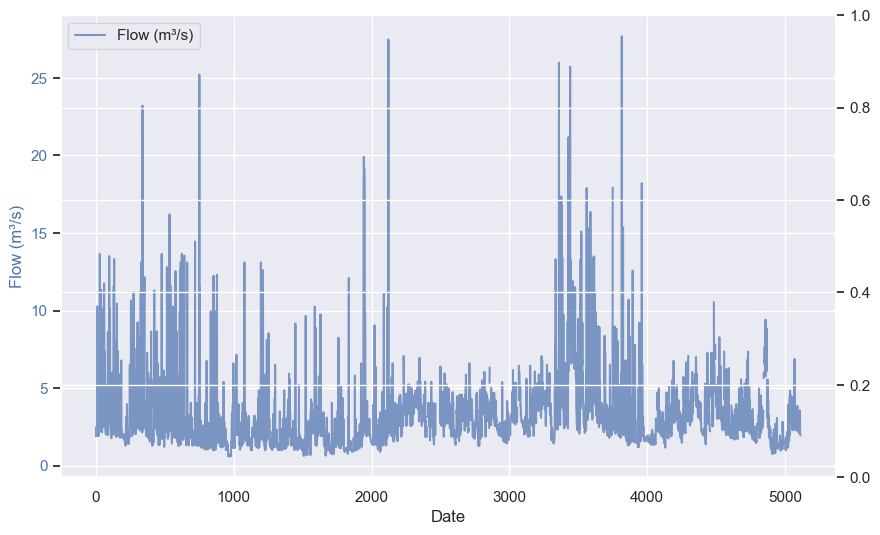

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data
dates = pd.date_range(start="2023-01-01", periods=100, freq='D')
flow = q_real  # Random flow data
precipitation = pptn  # Random precipitation data

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot flow data upwards
ax1.plot( flow, color='b', label='Flow (m³/s)', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Flow (m³/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

# Create a second y-axis for the precipitation data
ax2 = ax1.twinx()

# Scale precipitation data and add an offset to separate the plots
precipitation_offset = np.max(flow) * 1.1  # Offset by 10% more than the maximum flow value
scaled_precipitation = -precipitation + precipitation_offset

# Plot precipitation data downwards with an offset
ax2.plot( scaled_precipitation, color='g', alpha=0.5, width=1, label='Precipitation (mm)')
ax2.set_ylabel('Precipitation (mm)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='lower right')

# Add grid lines
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust the second y-axis to reflect the offset in the precipitation data
ax2.set_ylim(-np.max(precipitation), precipitation_offset * 1.1)

# Set title and show plot
plt.title('Flow and Precipitation Over Time')
plt.show()





In [1]:
import geopandas as gpd
import pandas as pd

In [10]:
df = pd.read_csv('cauces_intervenidos.csv',sep=';')
df2 = pd.read_csv('aforos2.csv',sep=';')

In [11]:
df2

,Estación,Corriente,Este,Norte
0,Río Nechí - GUA-Sed-1,Río Nechí,4728480,2318501
1,Río Nechí - GUA-Sed-3*,Río Nechí,4729694,2318909
2,Río Pajarito - GUA-Sed-2,Río Pajarito,4736317,2317583
3,Río Pajarito - GUA-Sed-4*,Río Pajarito,4736747,2317821
4,TC-12 Dolores,Río Dolores,4739461,2315107
5,Río Dolores - GUA-Sed-5*,Río Dolores,4739616,2315331
6,TC-2A La Holanda,Río Tenche,4746435,2311514


In [13]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Este, df.Norte), crs="EPSG:9377"
)
gdf.to_file('cauces_intervenidos')

gdf2 = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2.Este, df2.Norte), crs="EPSG:9377"
)
gdf2.to_file('puntos_aforos')